##Preprocessing of dataset

In [ ]:
!pip install kaggle #to install kaggle API

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
import json
from google.colab import files

uploaded = files.upload() # to upload the kaggle.json file

# directory to store kaggle api key
kaggle_path = os.path.expanduser('~/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

with open('kaggle.json', 'w') as f:
    f.write(uploaded['kaggle.json'].decode())

# Moving kaggle.json to correct location and set permissions
os.rename('kaggle.json', os.path.join(kaggle_path, 'kaggle.json'))
os.chmod(os.path.join(kaggle_path, 'kaggle.json'), 0o600)

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d manjilkarki/deepfake-and-real-images #downloading the dataset

Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown


In [ ]:
!unzip deepfake-and-real-images.zip #extract images from zip file

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Validation/Real/real_5499.jpg  
  inflating: Dataset/Validation/Real/real_55.jpg  
  inflating: Dataset/Validation/Real/real_550.jpg  
  inflating: Dataset/Validation/Real/real_5500.jpg  
  inflating: Dataset/Validation/Real/real_5501.jpg  
  inflating: Dataset/Validation/Real/real_5502.jpg  
  inflating: Dataset/Validation/Real/real_5503.jpg  
  inflating: Dataset/Validation/Real/real_5504.jpg  
  inflating: Dataset/Validation/Real/real_5505.jpg  
  inflating: Dataset/Validation/Real/real_5506.jpg  
  inflating: Dataset/Validation/Real/real_5507.jpg  
  inflating: Dataset/Validation/Real/real_5508.jpg  
  inflating: Dataset/Validation/Real/real_5509.jpg  
  inflating: Dataset/Validation/Real/real_551.jpg  
  inflating: Dataset/Validation/Real/real_5510.jpg  
  inflating: Dataset/Validation/Real/real_5511.jpg  
  inflating: Dataset/Validation/Real/real_5512.jpg  
  inflating: Dataset/Validation/Real/real_5513.jpg  

##Identfying size of the images in the dataset

In [ ]:
import os
from PIL import Image  # This library is used for opening and inspecting image files
from collections import Counter  # For counting occurrences of image dimensions

# Defining the main directory where the dataset is located
dataset_dir = "/content/Dataset"

# This function helps to collect unique image dimensions from a sub-directory
def get_image_dimensions(*subdirs):
    dimension_list = []
    for subdir in subdirs:
        dir_path = os.path.join(dataset_dir, subdir)
        for root, _, files in os.walk(dir_path):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):  #Check if the file is an image (case-insensitive)
                    file_path = os.path.join(root, file)
                    try:
                        with Image.open(file_path) as img:            # Opens the image and get its size (width, height)
                            dimension_list.append(img.size)           # Add the (width, height) tuple to the list
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")
    return Counter(dimension_list)

# collect the dimensions from all 3 sets
dimension_counts = get_image_dimensions("Training", "Validation", "Test")

# print results
print("Unique image dimensions and their counts:")
for dim, count in sorted(dimension_counts.items()):
    print(f"Size: ({dim[0]}x{dim[1]}) — {count} image(s)")

Unique image dimensions and their counts:
Size: (256x256) — 50333 image(s)


In [ ]:
train_dir = 'Dataset/Train'
validation_dir = 'Dataset/Validation'
test_dir = 'Dataset/Test'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset directories
base_dir = 'Dataset'

train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Test')

# Image dimensions
img_size = (150, 150)  # Resizing all images to 150x150 pixels
batch_size = 128

# ImageDataGenerators for each dataset split
datagen_args = dict(rescale=1./255)

# Creating ImageDataGenerators for each dataset split
train_datagen = ImageDataGenerator(**datagen_args)
validation_datagen = ImageDataGenerator(**datagen_args)
test_datagen = ImageDataGenerator(**datagen_args)

#loads images from the directory and applies the specified transformations
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'                #Binary classification (e.g., fake vs real)
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# This function counts the number of images in each class within a directory
def count_images(directory):
    counts = {
        class_name: len([
            file for file in os.listdir(os.path.join(directory, class_name))
            if os.path.isfile(os.path.join(directory, class_name, file))
        ])
        for class_name in os.listdir(directory)
        if os.path.isdir(os.path.join(directory, class_name))
    }
    return counts

# This function prints image counts for each dataset split
def print_image_counts(title, counts_dict):
    print(f"\n{title}")
    print("-" * len(title))
    for class_name, count in counts_dict.items():
        print(f"Class: {class_name:<10} | Images: {count}")
    print()

# Print image counts
print_image_counts("Training Set Image Counts", count_images(train_dir))
print_image_counts("Validation Set Image Counts", count_images(validation_dir))
print_image_counts("Test Set Image Counts", count_images(test_dir))

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.

Training Set Image Counts
-------------------------
Class: Real       | Images: 70001
Class: Fake       | Images: 70001


Validation Set Image Counts
---------------------------
Class: Real       | Images: 19787
Class: Fake       | Images: 19641


Test Set Image Counts
---------------------
Class: Real       | Images: 5413
Class: Fake       | Images: 5492



##Cropping the faces from the images in the dataset

In [ ]:
import cv2  #Import OpenCV for computer vision tasks

# Loading pre-trained Haar Cascade for face detection
face_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(face_cascade_path)

# Function to detect faces and return bounding box coordinates
def detect_faces(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Could not read image at: {image_path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert the image to grayscale for better face detection performance

    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1, #scale down the image by 10% each time
        minNeighbors=5, # Specifies how many neighboring rectangles a detection must have to be kept.
        minSize=(30, 30) #Ignores anything smaller than 30x30 pixels.
    )

    return [(x, y, x + w, y + h) for (x, y, w, h) in faces]  # Return the coordinates of the bounding box around each detected face

In [ ]:
import cv2
import random

# Function to detect and crop faces from a single image
def detect_and_crop_faces(image_path, output_dir):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(
        gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30)
    )

    os.makedirs(output_dir, exist_ok=True) #Creates the output folder to save the cropped images

    for i, (x, y, w, h) in enumerate(faces, start=1):
        cropped_face = img[y:y+h, x:x+w] # slicing - it crops the detected face from the original image
        output_filename = os.path.join(
            output_dir, f"face_{i}_{os.path.basename(image_path)}" #joins both the face number and original image name
        )
        if cv2.imwrite(output_filename, cropped_face): #It saves the cropped images
            print(f"Saved face {i} from {os.path.basename(image_path)} to {output_filename}")
        else:
            print(f"Failed to save face {i} from {image_path}")

# Function to iterate through dataset and crop faces from 50% randomly selected images
def detect_and_crop_faces_in_dataset(dataset_dir, output_dir):

  # Lists all files and folders in the directory
    for split in os.listdir(dataset_dir):
        split_path = os.path.join(dataset_dir, split)
        if not os.path.isdir(split_path):
            continue
        print("Split:", split)

        # Checking each class (Fake, Real) folder Checks that it’s a directory
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if not os.path.isdir(class_path):
                continue
            print("  Class:", class_name)

            output_class_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(output_class_dir, exist_ok=True)

            image_files = [
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ]
            random.shuffle(image_files)
            selected_files = image_files[:len(image_files) // 2]

            for image_file in selected_files:
                image_path = os.path.join(class_path, image_file)
                if os.path.isfile(image_path):
                    detect_and_crop_faces(image_path, output_class_dir)

# Define paths
dataset_dir = "/content/Dataset"
output_dir = "/content/Cropped_faces"

# Start the process
detect_and_crop_faces_in_dataset(dataset_dir, output_dir)

Streaming output truncated to the last 5000 lines.
Saved face 1 from fake_40676.jpg to /content/Cropped_faces/Train/Fake/face_1_fake_40676.jpg
Saved face 1 from fake_6645.jpg to /content/Cropped_faces/Train/Fake/face_1_fake_6645.jpg
Saved face 1 from fake_15841.jpg to /content/Cropped_faces/Train/Fake/face_1_fake_15841.jpg
Saved face 1 from fake_19229.jpg to /content/Cropped_faces/Train/Fake/face_1_fake_19229.jpg
Saved face 1 from fake_7927.jpg to /content/Cropped_faces/Train/Fake/face_1_fake_7927.jpg
Saved face 1 from fake_46762.jpg to /content/Cropped_faces/Train/Fake/face_1_fake_46762.jpg
Saved face 1 from fake_40678.jpg to /content/Cropped_faces/Train/Fake/face_1_fake_40678.jpg
Saved face 1 from fake_35077.jpg to /content/Cropped_faces/Train/Fake/face_1_fake_35077.jpg
Saved face 1 from fake_39801.jpg to /content/Cropped_faces/Train/Fake/face_1_fake_39801.jpg
Saved face 1 from fake_56161.jpg to /content/Cropped_faces/Train/Fake/face_1_fake_56161.jpg
Saved face 1 from fake_39071.jpg 

##Building the Model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Base directory for cropped face dataset
base_dir = '/content/Cropped_faces'

# Subdirectories for each dataset split
train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Test')

# Image resizing parameters and batch size
img_size = (150, 150)
batch_size = 256

# Image data generators with rescaling
datagen = ImageDataGenerator(rescale=1.0 / 255)

# this function prints the generator information
def print_generator_info(generator, name):
    print(f"\n{name} Set:")
    print(f"  Total images: {generator.samples}")
    print(f"  Batch size: {generator.batch_size}")
    print(f"  Target image size: {generator.target_size}")
    print(f"  Number of classes: {generator.num_classes}")
    print(f"  Class indices: {generator.class_indices}")
    print(f"  Classes distribution: {np.bincount(generator.classes)}")

# Create and summarize generators
train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)
print_generator_info(train_generator, "Train")

validation_generator = datagen.flow_from_directory(
    directory=validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)
print_generator_info(validation_generator, "Validation")

test_generator = datagen.flow_from_directory(
    directory=test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
print_generator_info(test_generator, "Test")

Found 65514 images belonging to 2 classes.

Train Set:
  Total images: 65514
  Batch size: 256
  Target image size: (150, 150)
  Number of classes: 2
  Class indices: {'Fake': 0, 'Real': 1}
  Classes distribution: [30420 35094]
Found 18433 images belonging to 2 classes.

Validation Set:
  Total images: 18433
  Batch size: 256
  Target image size: (150, 150)
  Number of classes: 2
  Class indices: {'Fake': 0, 'Real': 1}
  Classes distribution: [8569 9864]
Found 4855 images belonging to 2 classes.

Test Set:
  Total images: 4855
  Batch size: 256
  Target image size: (150, 150)
  Number of classes: 2
  Class indices: {'Fake': 0, 'Real': 1}
  Classes distribution: [2343 2512]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Building the CNN model architechture
def build_cnn_model(input_shape):
    return models.Sequential([                                     #stacks layers linearly from input to output
        layers.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=3, activation='relu'),       #First convolutional layer
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(64, kernel_size=3, activation='relu'),       #Second convolutional layer
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(128, kernel_size=3, activation='relu'),      #Third convolutional layer
        layers.MaxPooling2D(pool_size=2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification beyween real and fake
    ])

# setting input shape and creating the model
input_shape = (150, 150, 3)
model = build_cnn_model(input_shape)

# Compile the binary classification model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

##Model Training with Early Stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# setting maximum no of epochs
max_epochs = 50
patience = 5

# Initializing EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=patience,
    verbose=1,
    restore_best_weights=True
)

# Training the model with early stopping to prevent overfitiing
history = model.fit(
    train_generator,
    epochs=max_epochs,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

# Print accuracy for each epoch
for epoch_idx, acc in enumerate(history.history['accuracy'], start=1):
    print(f"Epoch {epoch_idx}: Accuracy = {acc}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 73s 274ms/step - accuracy: 0.6185 - loss: 0.6444 - val_accuracy: 0.8333 - val_loss: 0.4016
Epoch 2/50
  1/255 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8398 - loss: 0.4132

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



255/255 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.8398 - loss: 0.4132 - val_accuracy: 0.8255 - val_loss: 0.4042
Epoch 3/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 69s 270ms/step - accuracy: 0.8393 - loss: 0.3646 - val_accuracy: 0.8572 - val_loss: 0.3557
Epoch 4/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.8672 - loss: 0.3378 - val_accuracy: 0.8664 - val_loss: 0.3359
Epoch 5/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 69s 272ms/step - accuracy: 0.8806 - loss: 0.2813 - val_accuracy: 0.8531 - val_loss: 0.3306
Epoch 6/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9023 - loss: 0.2318 - val_accuracy: 0.8581 - val_loss: 0.3225
Epoch 7/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 69s 269ms/step - accuracy: 0.8984 - loss: 0.2442 - val_accuracy: 0.8850 - val_loss: 0.2755
Epoch 8/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.8984 - loss: 0.2263 - val_accuracy: 0.8872 - val_loss: 0.2699
Epoch 9/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 70s 274ms/step - accuracy: 0.9150 - loss: 0.2044 - val_acc

In [ ]:
# Resetting the test generator and predict
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_labels = (predictions > 0.5).astype(int).flatten()
true_labels = test_generator.classes

# Get class labels (0 is fake, 1 is Real)
index_to_label = {v: k for k, v in test_generator.class_indices.items()}
ordered_labels = [index_to_label[i] for i in range(len(index_to_label))]

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])

# Plot heatmap
import plotly.graph_objects as go
fig = go.Figure(data=go.Heatmap(
    z=conf_matrix,
    x=ordered_labels,  # Predicted
    y=ordered_labels,  # True
    colorscale='Blues',
    showscale=True,
    text=conf_matrix,
    texttemplate="%{text}"
))
fig.update_layout(
    title="Confusion Matrix",
    xaxis_title="Predicted Label",
    yaxis_title="True Label"
)
fig.show()

# Print matrix and classification report
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=ordered_labels))


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step


Confusion Matrix:
[[2110  233]
 [ 648 1864]]

Classification Report:
              precision    recall  f1-score   support

        Fake       0.77      0.90      0.83      2343
        Real       0.89      0.74      0.81      2512

    accuracy                           0.82      4855
   macro avg       0.83      0.82      0.82      4855
weighted avg       0.83      0.82      0.82      4855



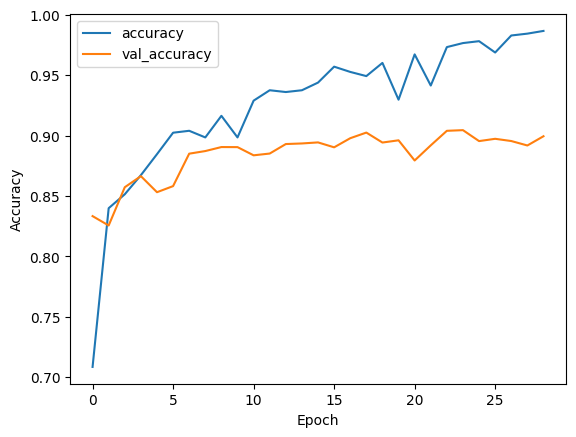

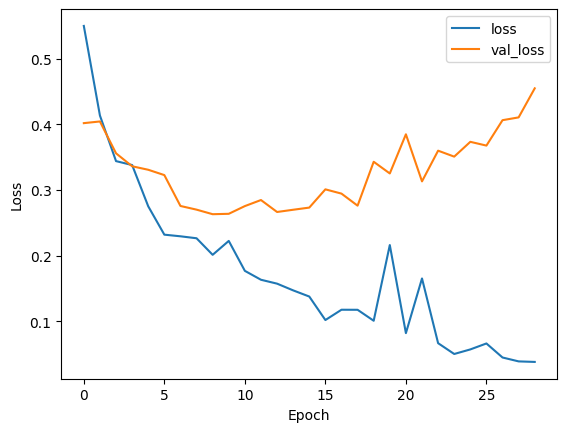

In [ ]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from PIL import Image
import os

# Defining image dimensions
IMG_WIDTH, IMG_HEIGHT = 150, 150

#this function loads and proceses the image
def preprocess_image(input_path):
    try:
        if not os.path.exists(input_path):
            raise FileNotFoundError(f"Local file not found: {input_path}")

        img = Image.open(input_path).convert('RGB')
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        img_array = np.array(img) / 255.0
        return np.expand_dims(img_array, axis=0)
    except Exception as e:
        print(f"Error loading or processing image: {e}")
        return None

#This function classifies images as real or fake
def classify_image(input_path):
    img_array = preprocess_image(input_path)
    if img_array is None:
        return "Error: Could not classify image"

    prediction = model.predict(img_array)
    return "Real" if prediction > 0.5 else "Fake"

# upload a test image
local_path = '/content/Dataset/Test/Fake/fake_1005.jpg'
print(f"Local image is classified as: {classify_image(local_path)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Local image is classified as: Fake
